## outcome 산출하기 

##### 시간대별 라이더 미노출 시간 boxplot -> q3보다 큰 값들은 라이더 풀이 부족한 것으로 판단하여 삭제함
##### 배차소요시간 ~ 고안시 초과 여부에 따른 roc 커브 그려서, 장미배 여부 기준 정함.  

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())

/Users/yj.noh/Documents/GitHub


In [2]:
holiday_list = pd.to_datetime([
    "2022-01-01", "2022-01-31", "2022-02-01", "2022-03-01", "2022-03-09",
    "2022-05-05", "2022-05-08", "2022-06-01", "2022-06-06", "2022-08-15",
    "2022-09-09", "2022-09-10", "2022-09-11", "2022-09-12", "2022-10-03",
    "2022-10-09", "2022-10-10", "2022-12-25", "2023-01-01", "2023-01-21",
    "2023-01-22", "2023-01-23", "2023-01-24", "2023-03-01", "2023-05-01",
    "2023-05-05", "2023-05-27", "2023-05-29", "2023-06-06", "2023-08-15",
    "2023-09-28", "2023-09-29", "2023-09-30", "2023-10-03", "2023-10-09",
    "2023-12-25"
])

plt.rcParams['font.family'] = 'AppleGothic'

## 1. data load + 파생변수 생성(요일, 공휴일 여부)

In [3]:
#data = pd.read_excel("prj-ML-model-LT_OV30/raw_data_final.xlsx")
data = pd.read_csv("prj-ML-model-LT_OV30/raw_data_final.csv", encoding = "utf-8")
print(data.shape) #115,823
#print(data.isna().sum())

(115823, 33)


In [4]:
# 추천미발생시간유 컬럼 값이 0.0 이상인 행만 선택
data = data[data['추천미발생시간유'] >= 0.0]

# 배차도해시간 합 < 전체배차시간인 것만 선택
data['chk'] = (data['추천노출시간_AI'] + data['추천노출시간_일반'] + data['추천미발생시간유'] + data['추천미발생시간무'] + data['배차후취소시간'] < data['전체배차시간']).astype(int)
data_filter = data[data['chk'] == 0]

print(data.shape) #115,803

(115803, 34)


In [5]:
# 요일
data_filter['business_day'] = pd.to_datetime(data_filter['business_day'])
data_filter.loc[:, 'day_of_week'] = data_filter['business_day'].dt.day_name().str[:3]
data_filter.loc[:, 'is_holiday'] = data_filter['business_day'].isin(holiday_list) | data_filter['day_of_week'].isin(["Fri", "Sat", "Sun"])

print(data_filter['day_of_week'].value_counts())
print(data_filter['is_holiday'].value_counts()) # 50,592, 40,028

day_of_week
Sun    13789
Sat    13534
Wed    13085
Tue    12993
Fri    12705
Mon    12523
Thu    11991
Name: count, dtype: int64
is_holiday
False    50592
True     40028
Name: count, dtype: int64


## 2. 시간대별 라이더미노출시간 비율 boxplot

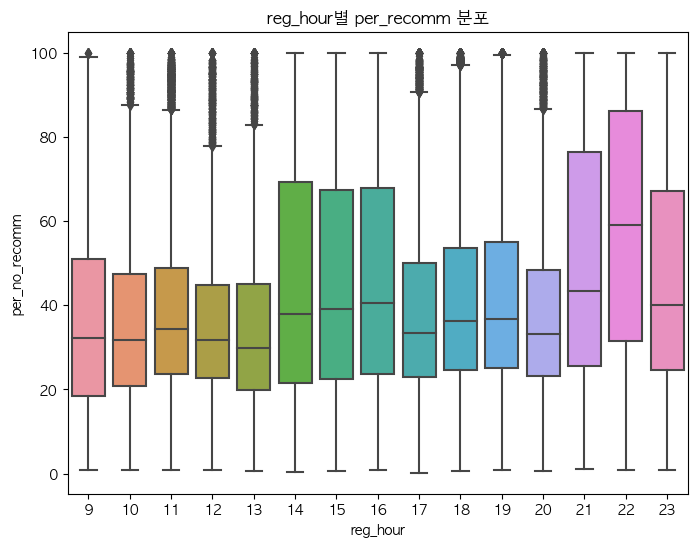

In [6]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='reg_hour', y='per_no_recomm')
plt.title("reg_hour별 per_recomm 분포")
plt.savefig("prj-ML-model-LT_OV30/graph/boxplot_per_recomm_by_reg_hour.png")
plt.show()

In [7]:
# reg_hour 별 per_recomm의 q3 구하기
#max_values = data_filter.groupby('reg_hour')['per_no_recomm'].max()
q3_values = data_filter.groupby('reg_hour')['per_no_recomm'].quantile(0.75)

# 최대값보다 작은 데이터만 필터링
data_rm = data_filter[data_filter.apply(lambda x: x['per_no_recomm'] <= q3_values[x['reg_hour']], axis=1)]

#print(data_rm.head())
print(data_rm.shape) #68,027

(68027, 36)


## 3. 전체배차소요시간 ~ 고안시 초과 여부(0/5/10/20) ROC 

In [8]:
conditions = {
    'output_5': 5,
    'output_10': 10,
    'output_20': 20
}

for column, value in conditions.items():
    data_rm.loc[:,column] = (data_rm['notiOver_min_max'] >= value).astype(int).astype('category')

data_rm.loc[:,'notiOver'] = data_rm['notiOver'].astype('category')

# 각 칼럼별 값의 빈도 확인하기
print(data_rm['output_5'].value_counts()) # 4226
print(data_rm['output_10'].value_counts()) # 1932
print(data_rm['output_20'].value_counts()) # 453


output_5
0    63803
1     4224
Name: count, dtype: int64
output_10
0    66097
1     1930
Name: count, dtype: int64
output_20
0    67574
1      453
Name: count, dtype: int64


In [9]:
print(data_rm.info())

<class 'pandas.core.frame.DataFrame'>
Index: 68027 entries, 1 to 115822
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dlvry_id               68027 non-null  object        
 1   business_day           68027 non-null  datetime64[ns]
 2   reg_hour               68027 non-null  int64         
 3   service_type           68027 non-null  object        
 4   shop_no                68027 non-null  int64         
 5   ord_price              68027 non-null  int64         
 6   notiOver               68027 non-null  category      
 7   actual_dlvry_distance  68027 non-null  int64         
 8   shop_loc_pnt_lat       68027 non-null  float64       
 9   shop_loc_pnt_lon       68027 non-null  float64       
 10  dlvry_loc_pnt_lat      68027 non-null  float64       
 11  dlvry_loc_pnt_lon      68027 non-null  float64       
 12  추천노출시간_AI              68027 non-null  float64       
 13  추천노출시

### 3-1. 각 output에 대한 boxplot

In [10]:
variables = ['notiOver', 'output_5', 'output_10', 'output_20']
file_names = ['boxplot_per_notiOver.png', 'boxplot_per_output_5.png', 'boxplot_per_output_10.png', 'boxplot_per_output_20.png']

for var, file_name in zip(variables, file_names):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data_rm, x=var, y='전체배차시간')
    plt.title(f"{var}별 전체배차시간")
    plt.savefig(f"prj-ML-model-LT_OV30/graph/{file_name}")
    plt.close()

### 3-2. 고안시 + N분 초과 < 배달시간 ROC 

In [11]:
def create_and_save_roc_plot(data, variable_name, output_file_name):

    boxplot_vals = data.groupby(variable_name)['전체배차시간'].describe()
    boxplot_max_0 = boxplot_vals.loc[0, '75%'] + 1.5 * (boxplot_vals.loc[0, '75%'] - boxplot_vals.loc[0, '25%'])
    boxplot_max_1 = boxplot_vals.loc[1, '75%'] + 1.5 * (boxplot_vals.loc[1, '75%'] - boxplot_vals.loc[1, '25%'])
    
    roc_df = data[((data[variable_name] == 0) & (data['전체배차시간'] <= boxplot_max_0)) |
                   ((data[variable_name] == 1) & (data['전체배차시간'] <= boxplot_max_1))]
    
    y_true = roc_df[variable_name].values
    y_scores = roc_df['전체배차시간'].values
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 최적의 임계값 찾기
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]
    
    # 그래프 그리기
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='red', label=f'AUC = {roc_auc:.3f}')
    plt.fill_between(fpr, tpr, color="#D1F2EB")
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
    plt.text(fpr[optimal_idx] + 0.02, tpr[optimal_idx] - 0.1, f'Sensitivity = {sensitivity:.3f}\nSpecificity = {specificity:.3f}\nOptimal threshold (cut-off value) = {optimal_threshold:.3f}', fontsize=12)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(output_file_name)
    #plt.show()
    
    return optimal_threshold
    #print(f'Optimal threshold (cut-off value) is: {optimal_threshold:.3f}')


5.35

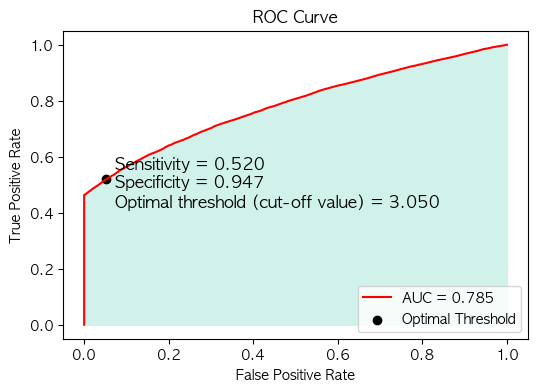

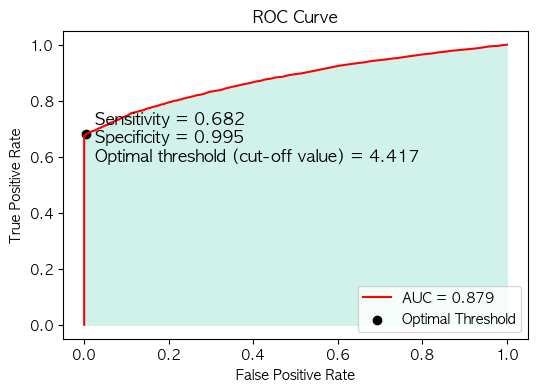

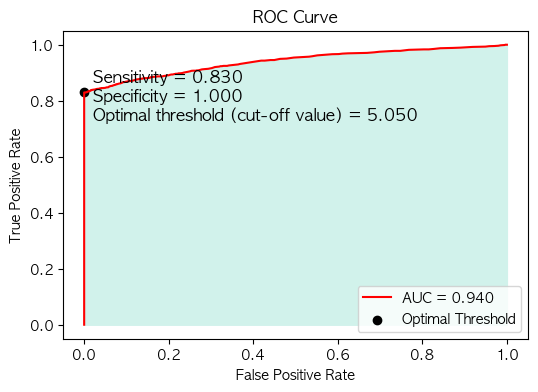

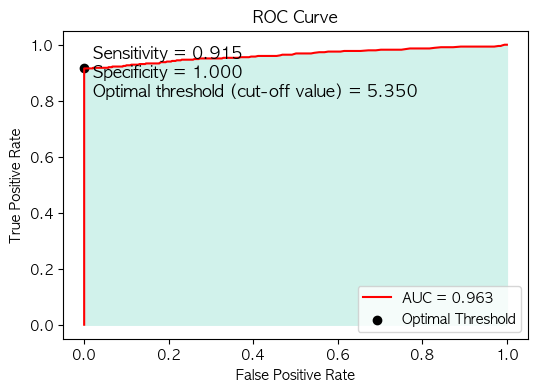

In [12]:
create_and_save_roc_plot(data_rm, 'notiOver', 'prj-ML-model-LT_OV30/graph/ROC_notiOver.png')
create_and_save_roc_plot(data_rm, 'output_5', 'prj-ML-model-LT_OV30/graph/ROC_output_5.png')
create_and_save_roc_plot(data_rm, 'output_10', 'prj-ML-model-LT_OV30/graph/ROC_output_10.png')
create_and_save_roc_plot(data_rm, 'output_20', 'prj-ML-model-LT_OV30/graph/ROC_output_20.png')


## 4. 장기미배차 기준 정하기 
##### 고안시 초과 10분을 결정짓는 threshold값보다 전체배차시간이 크면 1, 아니면 0인 값으로 모델 outcome 결정

outcome
0    59146
1     8881
Name: count, dtype: int64


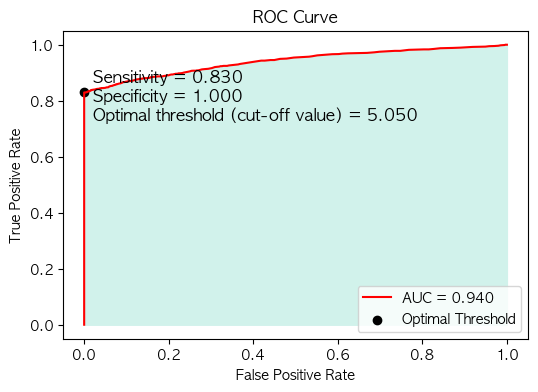

In [13]:
y_value = create_and_save_roc_plot(data_rm, 'output_10', 'prj-ML-model-LT_OV30/graph/ROC_output_10.png')
data_rm['outcome'] = np.where(data_rm['전체배차시간'] > y_value, 1, 0)
print(data_rm['outcome'].value_counts()) # 59146, 8881

## 5. weather 데이터 join

In [14]:
weather = pd.read_csv("prj-ML-model-LT_OV30/weather.csv", encoding="cp949")

weather['일시'] = pd.to_datetime(weather['일시'])
weather['시간'] = weather['일시'].dt.hour
weather['일시'] = weather['일시'].dt.strftime('%Y-%m-%d')
weather = weather.fillna(0)

weather = weather[(weather['시간'] >= 8) & (weather['시간'] <= 22)]
weather.rename(columns={"기온(°C)":'기온',"강수량(mm)":'강수량'},inplace=True)

print(weather.head())

     지점 지점명          일시    기온  강수량  시간
8   108  서울  2023-08-21  27.4  0.0   8
9   108  서울  2023-08-21  28.8  0.0   9
10  108  서울  2023-08-21  30.2  0.0  10
11  108  서울  2023-08-21  31.1  0.0  11
12  108  서울  2023-08-21  32.3  0.0  12


In [15]:
data_rm['business_day'] = data_rm['business_day'].dt.strftime('%Y-%m-%d')
print(data_rm.head())

merged_data = data_rm.merge(weather, left_on='business_day', right_on='일시')
filtered_data = merged_data[(merged_data['reg_hour']-1 == merged_data['시간'])]

print(filtered_data.shape) #68027 

            dlvry_id business_day  reg_hour service_type   shop_no  ord_price  \
1  20230827_9376QTJN   2023-08-27        11          배민1  13662067      22500   
2  20230901_6002ZAHY   2023-09-01        18          배민1  13484712      29500   
4  20230903_9960FXEM   2023-09-03        15          배민1  13853940      15300   
5  20230821_9294SBDY   2023-08-21        22          배민1  13977296      15000   
6  20230822_1739TYQM   2023-08-22        18          배민1  13007319      22000   

  notiOver  actual_dlvry_distance  shop_loc_pnt_lat  shop_loc_pnt_lon  ...  \
1        1                   1274         37.511156        127.018963  ...   
2        0                    612         37.468800        127.041213  ...   
4        0                    916         37.514128        127.017963  ...   
5        0                   1478         37.495991        127.025241  ...   
6        1                   1379         37.477608        126.982164  ...   

   dlvry_지상층수  dlvry_지하층수  dlvry_건물용도  chk  

In [16]:
filtered_data[['dlvry_rgn1_nm', 'dlvry_rgn2_nm', 'dlvry_rgn3_nm', 'etc']] = filtered_data['dlvry_address'].str.split(' ', n=3, expand=True)
print(filtered_data.columns)

Index(['dlvry_id', 'business_day', 'reg_hour', 'service_type', 'shop_no',
       'ord_price', 'notiOver', 'actual_dlvry_distance', 'shop_loc_pnt_lat',
       'shop_loc_pnt_lon', 'dlvry_loc_pnt_lat', 'dlvry_loc_pnt_lon',
       '추천노출시간_AI', '추천노출시간_일반', '추천미발생시간유', '추천미발생시간무', '배차후취소시간', '전체배차시간',
       'notiOver_min_max', 'per_display', 'per_no_recomm', 'pick_floor',
       'pick_rgn2_nm', 'pick_rgn3_nm', 'pick_category', 'pick_건물용도',
       'pick_address', 'Latitude', 'Longitude', 'dlvry_address', 'dlvry_지상층수',
       'dlvry_지하층수', 'dlvry_건물용도', 'chk', 'day_of_week', 'is_holiday',
       'output_5', 'output_10', 'output_20', 'outcome', '지점', '지점명', '일시',
       '기온', '강수량', '시간', 'dlvry_rgn1_nm', 'dlvry_rgn2_nm', 'dlvry_rgn3_nm',
       'etc'],
      dtype='object')


### 6. 데이터 저장

In [17]:
filtered_data.to_csv('prj-ML-model-LT_OV30/data_final.csv', index=False, encoding = "cp949")

model_df = filtered_data[['dlvry_id', '전체배차시간', 'reg_hour', 'ord_price','actual_dlvry_distance', 'pick_floor',
       'pick_rgn2_nm', 'pick_rgn3_nm', 'pick_category', 'pick_건물용도','dlvry_지상층수', 'dlvry_지하층수',
       'dlvry_건물용도','day_of_week', 'is_holiday', '기온', '강수량', 'dlvry_rgn2_nm', 'dlvry_rgn3_nm', 'outcome'
       ]]

model_df.to_csv('prj-ML-model-LT_OV30/modeling_data.csv', index=False, encoding="cp949")
